In [ ]:
from google.colab import drive # the real images data files take too long (about 17 minutes) to be downloaded, so we just mount it
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tar -xzf /content/drive/MyDrive/nuimages/nuimages-v1.0-all-metadata.tgz && tar -xzf /content/drive/MyDrive/nuimages/nuimages-v1.0-all-samples.tgz # extract. this will take about 7 minutes

In [ ]:
drive.flush_and_unmount() # unmount when we don't need it anymore, so we have more disk space

In [ ]:
!mkdir train2017 val2017 annotations

In [ ]:
import json
import pandas as pd
import datetime

def data_json_to_joined_df(path_prefix_to_json, percent = 100, random_sample=False):
    # percent: take only certain percent of the images
    # random_sample: True if you want to randomize which images to take

    category = pd.read_json(path_prefix_to_json + 'category.json').rename(columns={"name": "category_name"})
    category = category.sort_values(by='category_name')
    category['category_id'] = range(len(category))

    obj_ann = pd.read_json(path_prefix_to_json + 'object_ann.json')
    sample_data = pd.read_json(path_prefix_to_json + 'sample_data.json')
    sample_data = sample_data[sample_data['filename'].str.startswith('sample')] # take only keyframe images (annotated images) which always start with 'samples'. sweeps images are not annotated
    n_rows = int(len(sample_data) * (percent / 100))
    if random_sample:
        sample_data = sample_data.sample(n = n_rows)
    else:
        sample_data = sample_data.iloc[:n_rows]

    # object annotation inner join sample_data
    merged = obj_ann.merge(
        sample_data,
        how = 'inner',
        right_on='token',
        left_on='sample_data_token',
        suffixes=('_left', '_right')
    )

    merged = merged.merge(
        category,
        how = 'left',
        left_on='category_token',
        right_on='token',
        suffixes=('_from_merged', '_from_category')
    )

    return merged

# create list of train/val/test image file name list in a txt file (train/val.txt), so we can use cp/rsync with it
def create_image_filename_list_txt(data_split, merged_df):
    if data_split not in ['train', 'val', 'test']:
        return -1

    df = merged_df[['filename']]
    filenames = set([])
    for index, row in df.iterrows():
        filenames.add(row['filename'])
    for fn in filenames:
        with open(data_split+".txt", 'a') as f:
            f.write(fn + "\n")

def df_to_coco_format(merged_df, path_prefix, split): # DETR uses COCO format
    if split not in ['val', 'train']:
        return -1

    df = merged_df[['filename', 'bbox', 'category_id', 'category_name', 'width', 'height']]

    coco_dict = {"images": [], "annotations": [], "categories": []}
    coco_dict["info"] = { # not including this will cause error during training
        "description": "Nothing",
        "url": "https://github.com/nobody/nothing",
        "version": "2.0.2",
        "year": 2025,
        "contributor": "nobody",
        "date_created": datetime.datetime.utcnow().isoformat(" "),
    }

    is_image_added = {}
    filename_to_id = {}

    id = 0

    # build images
    for i, row in df.iterrows():
        if row['filename'] not in is_image_added: # if image not added yet, then add
            coco_dict["images"].append({
                "id": id,
                "width": row['width'],
                "height": row['height'],
                "file_name": row['filename'].split("/")[-1],
            })
            filename_to_id[row['filename']] = id
            id += 1
            is_image_added[row['filename']] = True

    # build annotations
    for i, row in df.iterrows():
        xmin, ymin, xmax, ymax = row['bbox'][0], row['bbox'][1], row['bbox'][2], row['bbox'][3]
        coco_dict["annotations"].append({
            "id": i,
            "image_id": filename_to_id[row['filename']],
            "category_id": row['category_id'],
            "area": (xmax - xmin) * (ymax - ymin),
            "bbox": [xmin, ymin, xmax - xmin, ymax - ymin], # top left, width, height
            "iscrowd": 0, # not including this will cause an error during training
            "date_captured": datetime.datetime.utcnow().isoformat(" "),
            "license": 0,
            "flickr_url": "",
            "coco_url": ""
        })


    # build category
    category = pd.read_json(path_prefix + 'category.json').rename(columns={"name": "category_name"})
    category = category.sort_values(by='category_name')

    for i, row in category.iterrows():
        coco_dict["categories"].append({
            "id": i,
            "name": row["category_name"],
        })

    with open(split + ".json", "w") as file:
        file.write(json.dumps(coco_dict))


In [ ]:
val_df = data_json_to_joined_df('/content/v1.0-val/',1, random_sample=False)
train_df = data_json_to_joined_df('/content/v1.0-train/',1, random_sample=False)

In [ ]:
create_image_filename_list_txt('train', train_df)
create_image_filename_list_txt('val', val_df)

In [ ]:
# make sure the val.txt exists before running this
# copy the val image to directory expected by yolo. should take about 1 minute for the entire dataset
!xargs -a val.txt -P8 -I{} cp "/content/{}" /content/val2017/

In [ ]:
# make sure the train.txt exists before running this
# copy the train image to directory expected by yolo. should take about 5 minutes for the entire dataset
!xargs -a train.txt -P8 -I{} cp "/content/{}" /content/train2017/

In [ ]:
df_to_coco_format(val_df, '/content/v1.0-val/', 'val')
df_to_coco_format(train_df, '/content/v1.0-train/', 'train')

In [ ]:
!pip install pycocotools

In [ ]:
!pip install scikit-image

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
File name:  n013-2018-08-17-15-26-47+0800__CAM_FRONT__1534491323112407.jpg
Image path:  /content/train2017/n013-2018-08-17-15-26-47+0800__CAM_FRONT__1534491323112407.jpg


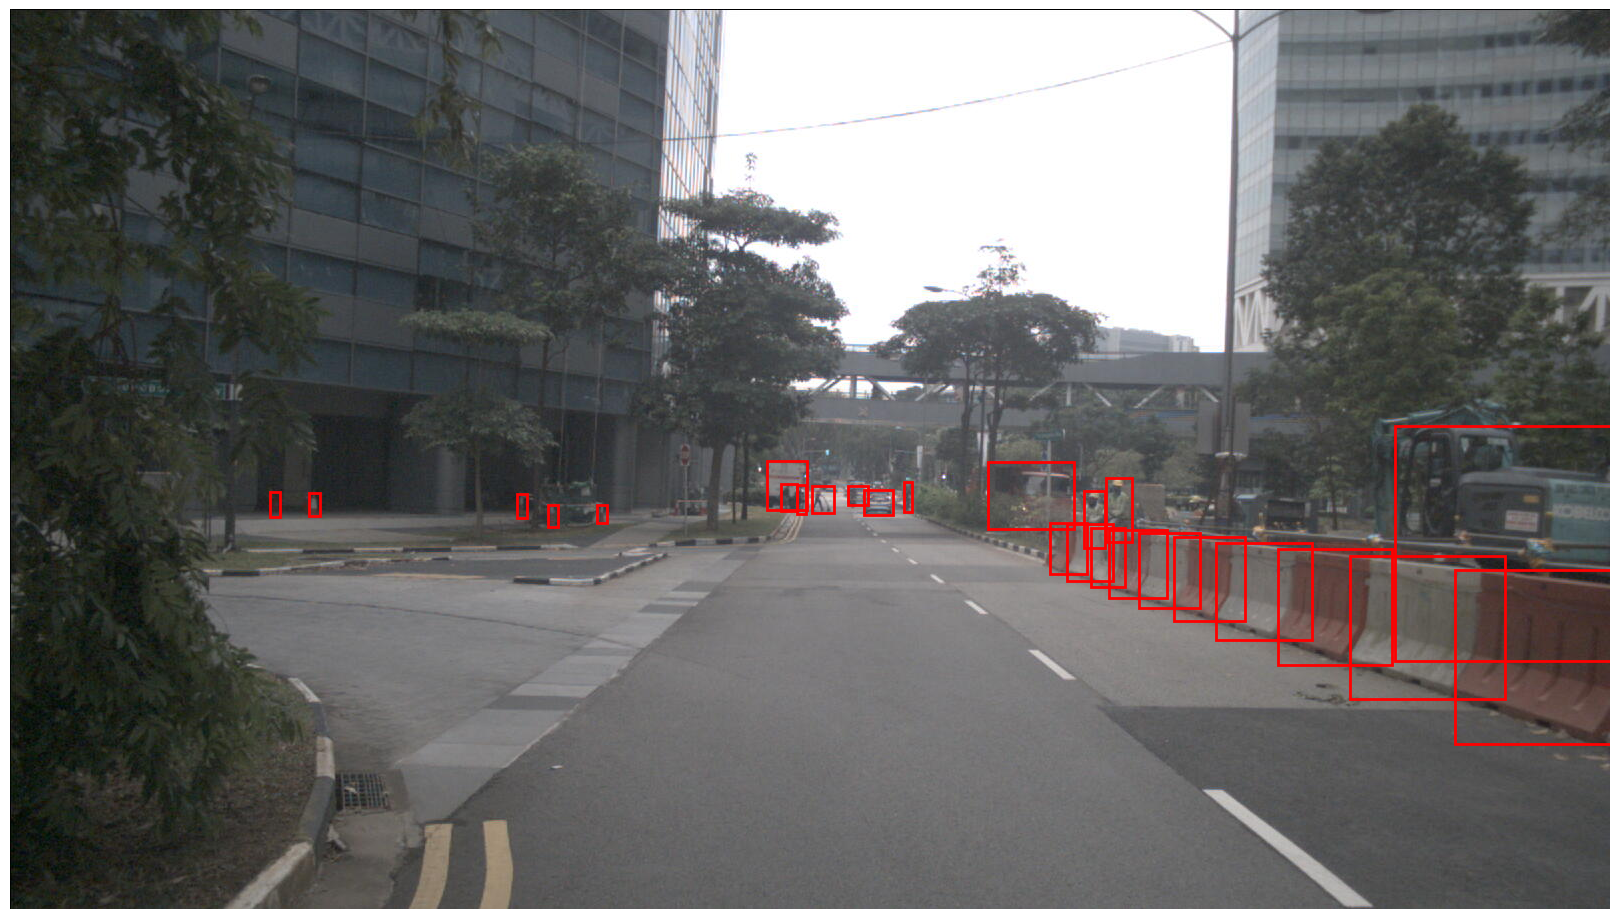

In [ ]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import os
import random

ann_file = '/content/train.json'
img_dir = '/content/train2017/'

coco = COCO(ann_file)

imgIds = coco.getImgIds()
img_id = imgIds[random.randint(1, len(imgIds)-1)]
img_info = coco.loadImgs(img_id)[0]
print ("File name: ", img_info['file_name'])
img_path = os.path.join(img_dir, img_info['file_name'])
print ("Image path: ", img_path)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

ann_ids = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(ann_ids)

dpi = 100
height, width = img.shape[:2]
figsize = (width / dpi, height / dpi)

fig, ax = plt.subplots(1, figsize=figsize, dpi=dpi)
ax.imshow(img)

for ann in anns:
    x, y, w, h = ann['bbox']
    rect = patches.Rectangle((x, y), w, h, linewidth=2,
                             edgecolor='r', facecolor='none')
    ax.add_patch(rect)

ax.axis('off')
plt.tight_layout(pad=0)
plt.show()



# Training
This part uses the link below as the reference
https://colab.research.google.com/github/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb#scrollTo=rFmDKP0SavNt

In [ ]:
!cp /content/train.json /content/annotations/custom_train.json

In [ ]:
!cp /content/val.json /content/annotations/custom_val.json

In [ ]:
%cd /content/

!rm -rf detr
!git clone https://github.com/woctezuma/detr.git

%cd detr/

!git checkout finetune

/content
Cloning into 'detr'...
remote: Enumerating objects: 265, done.
remote: Total 265 (delta 0), reused 0 (delta 0), pack-reused 265 (from 1)
Receiving objects: 100% (265/265), 325.44 KiB | 25.03 MiB/s, done.
Resolving deltas: 100% (127/127), done.
/content/detr
Already on 'finetune'
Your branch is up to date with 'origin/finetune'.


In [ ]:
import torch

In [ ]:
# Get pretrained weights
checkpoint = torch.hub.load_state_dict_from_url(
            url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
            map_location='cpu',
            check_hash=True)

# Remove class weights
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]

# Save
torch.save(checkpoint,
           'detr-r50_no-class-head.pth')

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth
100%|██████████| 159M/159M [00:07<00:00, 22.0MB/s]


In [ ]:
first_class_index = 0

In [ ]:
def get_classes_list(path_prefix):
  category = pd.read_json(path_prefix + 'category.json').rename(columns={"name": "category_name"})
  category = category.sort_values(by='category_name')
  return category['category_name'].tolist()

finetuned_classes = get_classes_list('/content/v1.0-train/')
num_classes = len(finetuned_classes)
num_classes

25

In [ ]:
%cd /content/detr/

/content/detr


In [66]:
# DETR seems to consume way more GPU RAM than YOLO, use hyperparam like batch size or epoch wisely
!python main.py \
  --dataset_file "custom" \
  --coco_path "/content/" \
  --output_dir "outputs" \
  --resume "detr-r50_no-class-head.pth" \
  --num_classes $num_classes \
  --epochs 2 \
  --batch_size 4

Not using distributed mode
git:
  sha: e891373a8cab93d3719afb0acff28de94c6dc6a3, status: clean, branch: finetune

Namespace(lr=0.0001, lr_backbone=1e-05, batch_size=4, weight_decay=0.0001, epochs=2, lr_drop=200, clip_max_norm=0.1, frozen_weights=None, backbone='resnet50', dilation=False, position_embedding='sine', enc_layers=6, dec_layers=6, dim_feedforward=2048, hidden_dim=256, dropout=0.1, nheads=8, num_queries=100, pre_norm=False, masks=False, aux_loss=True, set_cost_class=1, set_cost_bbox=5, set_cost_giou=2, mask_loss_coef=1, dice_loss_coef=1, bbox_loss_coef=5, giou_loss_coef=2, eos_coef=0.1, num_classes=25, dataset_file='custom', coco_path='/content/', coco_panoptic_path=None, remove_difficult=False, output_dir='outputs', device='cuda', seed=42, resume='detr-r50_no-class-head.pth', start_epoch=0, eval=False, num_workers=2, world_size=1, dist_url='env://', distributed=False)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretra

# Testing fine-tuning/training result
Adopted from here https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_attention.ipynb#scrollTo=8yls9cpVYTEg

In [67]:
from argparse import Namespace

torch.serialization.add_safe_globals([Namespace])

model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes,
                           )

checkpoint = torch.load('outputs/checkpoint.pth',
                        map_location='cpu')

model.load_state_dict(checkpoint['model'],
                      strict=False)

model.eval();

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [68]:
from PIL import Image
image = Image.open("/content/train2017/n003-2018-01-03-12-03-23+0800__CAM_BACK_RIGHT__1514952966577338.jpg")

In [69]:

import torchvision.transforms as T

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [72]:
# mean-std normalize the input image (batch-size: 1)
img = transform(image).unsqueeze(0)

# propagate through the model
outputs = model(img)

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.5

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], image.size)

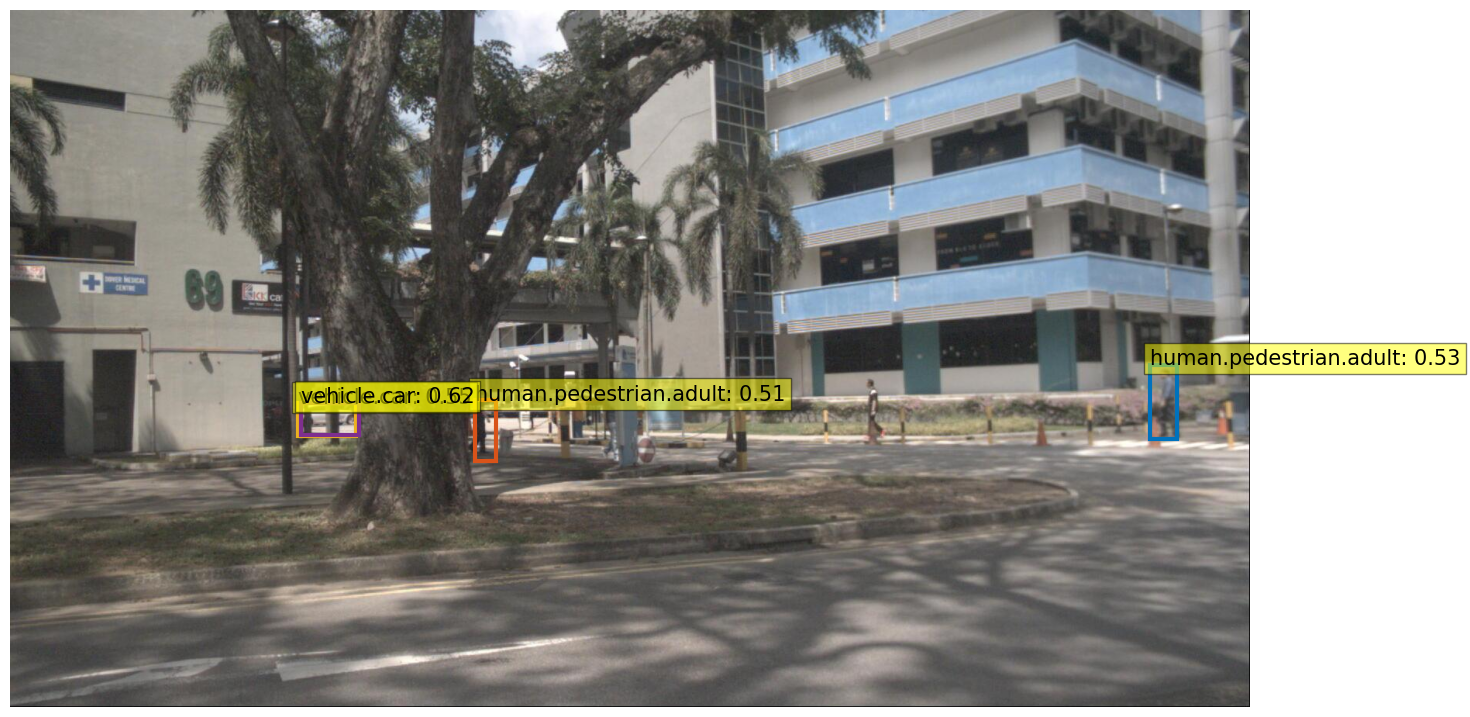

In [73]:
plot_results(image, probas[keep], bboxes_scaled)